# BCG Argo data
Code comes from BGC-Argo Workshop: https://github.com/Flavi1P/apart_demo

In [1]:
# Loading libraries
import argopy as ar
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Downloaded data from argo located within near the southern Icelandic shelf

In [2]:
ds = ar.DataFetcher(src="gdac").float(7902223).to_xarray()
with ar.set_options(mode='expert'):
    ds_bgc = ar.DataFetcher(backend='erddap', ds = 'bgc').float(7902223).to_xarray()
prof = ar.ArgoFloat(7902223).open_dataset('prof')

In [3]:
display(ds)
display(ds_bgc)

<xarray.Dataset> Size: 1MB
Dimensions:          (N_POINTS: 9759)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 78kB 2024-09-02T20:07:37 ... 2...
    LATITUDE         (N_POINTS) float64 78kB 62.37 62.37 62.37 ... 63.2 63.2
    LONGITUDE        (N_POINTS) float64 78kB -18.76 -18.76 ... -30.13 -30.13
  * N_POINTS         (N_POINTS) int64 78kB 0 1 2 3 4 ... 9755 9756 9757 9758
Data variables: (12/15)
    CYCLE_NUMBER     (N_POINTS) int64 78kB 1 1 1 1 1 1 1 ... 46 46 46 46 46 46
    DATA_MODE        (N_POINTS) <U1 39kB 'R' 'R' 'R' 'R' 'R' ... 'R' 'R' 'R' 'R'
    DIRECTION        (N_POINTS) <U1 39kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 78kB 7902223 7902223 ... 7902223 7902223
    POSITION_QC      (N_POINTS) int64 78kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float32 39kB 3.5 4.6 5.6 ... 1.126e+03 1.15e+03
    ...               ...
    PSAL_ERROR       (N_POINTS) float32 39kB nan nan nan nan ... nan nan nan nan
    PSAL_QC          (N_POINTS) int64 78kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float32 39kB 11.52 11.52 11.52 ... 3.886 3.743
    TEMP_ERROR       (N_POINTS) float32 39kB nan nan nan nan ... nan nan nan nan
    TEMP_QC          (N_POINTS) int64 78kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 78kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_by:           davidlewis
    Fetched_constraints:  WMO7902223
    Fetched_date:         2025/09/06
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/7902223/7...
    Processing_history:   Transformed with 'profile2point'; URI merged with '...
    raw_attrs:            {'title': 'Argo float vertical profile', 'instituti...

<xarray.Dataset> Size: 21MB
Dimensions:                            (N_POINTS: 42076)
Coordinates:
    LATITUDE                           (N_POINTS) float64 337kB ...
    LONGITUDE                          (N_POINTS) float64 337kB ...
    TIME                               (N_POINTS) datetime64[ns] 337kB ...
  * N_POINTS                           (N_POINTS) int64 337kB 0 1 ... 42075
Data variables: (12/84)
    BBP700                             (N_POINTS) float32 168kB ...
    BBP700_ADJUSTED                    (N_POINTS) float32 168kB ...
    BBP700_ADJUSTED_ERROR              (N_POINTS) float32 168kB ...
    BBP700_ADJUSTED_QC                 (N_POINTS) int64 337kB 0 0 0 3 ... 0 1 0
    BBP700_DATA_MODE                   (N_POINTS) <U1 168kB 'A' 'A' ... 'A' 'A'
    BBP700_QC                          (N_POINTS) int64 337kB 0 0 0 3 ... 0 1 0
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 168kB ...
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 168kB ...
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 337kB 8 8 8 8 ... 1 8 8
    TEMP_DATA_MODE                     (N_POINTS) <U1 168kB 'R' 'R' ... 'R' 'R'
    TEMP_QC                            (N_POINTS) int64 337kB 3 3 3 3 ... 1 8 8
    TIME_QC                            (N_POINTS) int64 337kB 1 1 1 1 ... 1 1 1
Attributes:
    DATA_ID:              ARGO-BGC
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           davidlewis
    Fetched_date:         2025/09/06
    Fetched_constraints:  WMO7902223
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...

## Float Trajectory

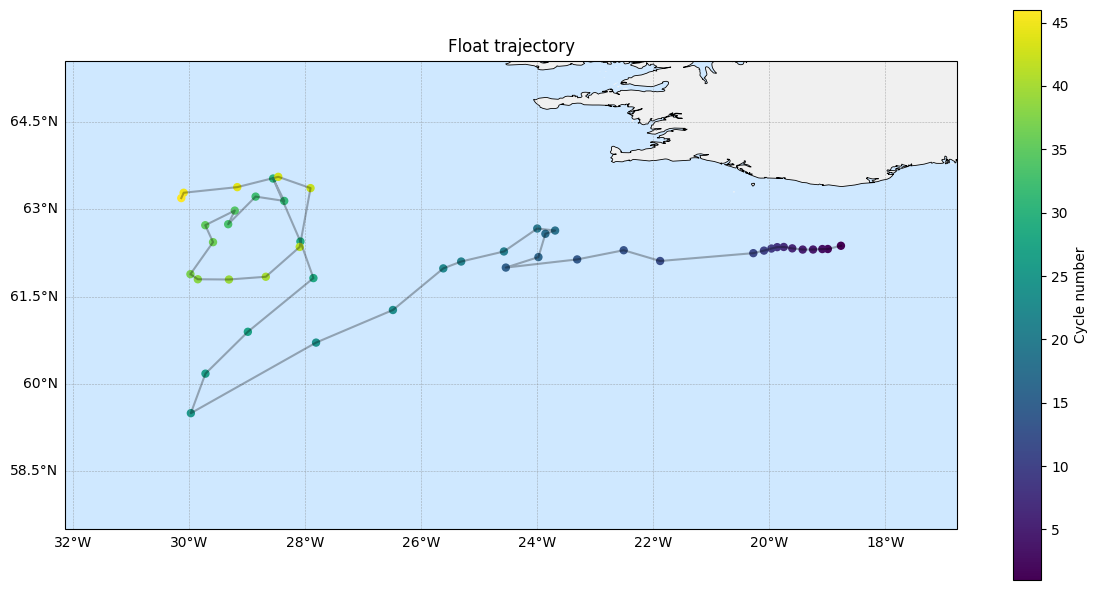

In [4]:
# Full credit goes to chat gpt here
# Extract arrays
lon = np.asarray(prof['LONGITUDE'].values)
lat = np.asarray(prof['LATITUDE'].values)
cyc = np.asarray(prof['CYCLE_NUMBER'].values)

# Normalize longitudes to [-180, 180] if your data are 0–360
if np.nanmin(lon) >= 0:
    lon = ((lon + 180) % 360) - 180

# Nice map extent with small padding
pad = 2
extent = [np.nanmin(lon)-pad, np.nanmax(lon)+pad,
          np.nanmin(lat)-pad, np.nanmax(lat)+pad]

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Background features
ax.add_feature(cfeature.OCEAN, facecolor='#cfe8ff')
ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = gl.right_labels = False

# Trajectory: line + colored points
ax.plot(lon, lat, '-', color='k', alpha=0.3, transform=ccrs.PlateCarree())
sc = ax.scatter(lon, lat, c=cyc, s=25, cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='Cycle number')

plt.title('Float trajectory')
plt.tight_layout()
plt.show()


In [5]:
def plot_transect(ds, varname, depth_min = 0, depth_max = 300, log_scale=False):
    # Build dataset from point-form arrays
    ds_points = xr.Dataset(
        {
            "VAR": ("obs", ds[varname].values),
            "PRES": ("obs", ds['PRES'].values),
            "TIME": ("obs", ds['TIME'].values)
        }
    )

    # Unique profile times
    times_unique = np.unique(ds_points['TIME'].values)

    # Regular pressure grid
    depth_grid = np.arange(depth_min, depth_max, 2)  # adjust range and step as needed

    profiles = []
    for t in times_unique:
        # Select all measurements at this time
        mask_time = ds_points['TIME'].values == t
        pres_vals = ds_points['PRES'].values[mask_time]
        var_vals = ds_points['VAR'].values[mask_time]
        
        # Drop NaNs before interpolation
        mask_valid = np.isfinite(pres_vals) & np.isfinite(var_vals)
        if mask_valid.sum() > 1:
            var_interp = np.interp(depth_grid, pres_vals[mask_valid], var_vals[mask_valid],
                                    left=np.nan, right=np.nan)
        else:
            var_interp = np.full_like(depth_grid, np.nan, dtype=float)
        profiles.append(var_interp)

    # Convert to xarray DataArray for plotting
    var_section = xr.DataArray(
        np.array(profiles),
        coords={"TIME": times_unique, "PRES": depth_grid},
        dims=("TIME", "PRES")
    )
    units = ds[varname].attrs['units']

    # Plot section
    plt.figure(figsize=(12, 6))
    if log_scale:
        pcm = plt.pcolormesh(
        var_section['TIME'],
        var_section['PRES'],
        var_section.T,
        shading='auto',
        cmap='viridis',
        norm=LogNorm(vmin=1e-3, vmax=np.nanmax(var_section))  # adjust vmin as needed
    )
    else:
        pcm = plt.pcolormesh(var_section['TIME'], var_section['PRES'], var_section.T,
                            shading='auto', cmap='viridis')
    plt.gca().invert_yaxis()
    plt.colorbar(pcm, label=f'{varname} {units}')
    plt.xlabel('Time')
    plt.ylabel('Pressure (dbar)')
    plt.title(f'BGC-Argo {varname} Section (Depth vs Time)')
    plt.tight_layout()
    plt.show()

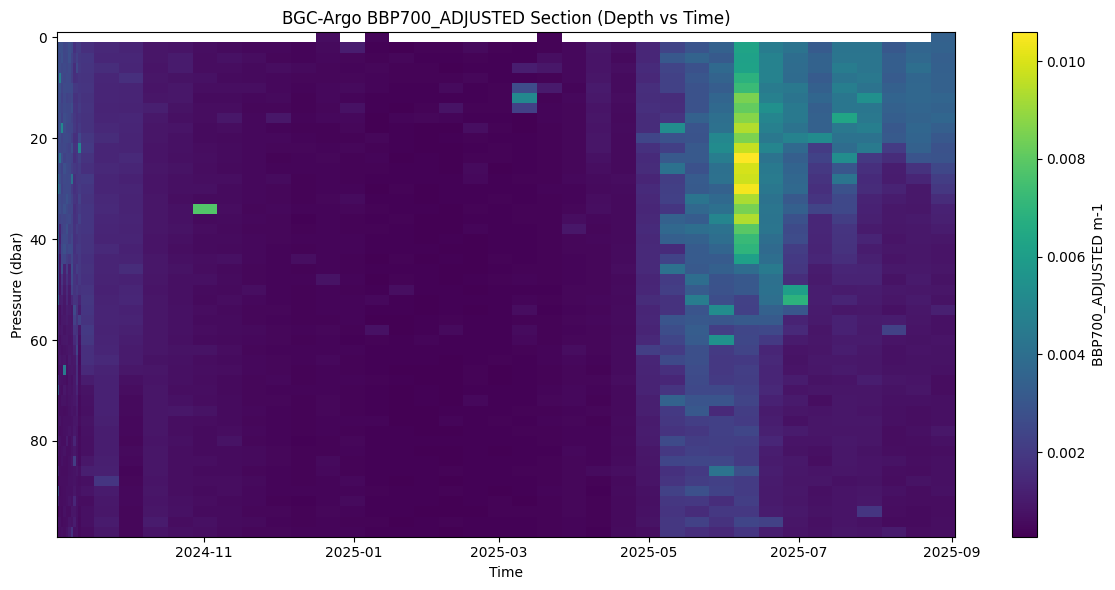

In [6]:
plot_transect(ds_bgc, 'BBP700_ADJUSTED', depth_max = 100, log_scale=False)

In [7]:
plot_interpolated_section(ds_bgc, 'BBP700_ADJUSTED', depth_max=100, log_scale=True)

NameError: name 'plot_interpolated_section' is not defined

In [ ]:
ds = ar.DataFetcher(src="gdac").float(1902645).to_xarray()
with ar.set_options(mode='expert'):
    ds_bgc = ar.DataFetcher(backend='erddap', ds = 'bgc').float(1902645).to_xarray()
prof = ar.ArgoFloat(1902645).open_dataset('prof')

In [ ]:
# Full credit goes to chat gpt here
# Extract arrays
lon = np.asarray(prof['LONGITUDE'].values)
lat = np.asarray(prof['LATITUDE'].values)
cyc = np.asarray(prof['CYCLE_NUMBER'].values)

# Normalize longitudes to [-180, 180] if your data are 0–360
if np.nanmin(lon) >= 0:
    lon = ((lon + 180) % 360) - 180

# Nice map extent with small padding
pad = 2
extent = [np.nanmin(lon)-pad, np.nanmax(lon)+pad,
          np.nanmin(lat)-pad, np.nanmax(lat)+pad]

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Background features
ax.add_feature(cfeature.OCEAN, facecolor='#cfe8ff')
ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = gl.right_labels = False

# Trajectory: line + colored points
ax.plot(lon, lat, '-', color='k', alpha=0.3, transform=ccrs.PlateCarree())
sc = ax.scatter(lon, lat, c=cyc, s=25, cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='Cycle number')

plt.title('Float trajectory')
plt.tight_layout()
plt.show()

plot_transect(ds_bgc, 'BBP700_ADJUSTED', depth_max = 100, log_scale=False)

In [ ]:

def plot_interpolated_section(ds_bgc, varname='CHLA_ADJUSTED', depth_min=0, depth_max=300, log_scale=True):
    # Build dataset from point-form arrays
    ds_points = xr.Dataset(
        {
            "VAR": ("obs", ds_bgc[varname].values),
            "PRES": ("obs", ds_bgc['PRES'].values),
            "TIME": ("obs", ds_bgc['TIME'].values)
        }
    )

    # Unique profile times
    times_unique = np.unique(ds_points['TIME'].values)

    # Regular pressure grid
    depth_grid = np.arange(depth_min, depth_max + 1, 1)  # include depth_max

    profiles = []
    for t in times_unique:
        mask_time = ds_points['TIME'].values == t
        pres_vals = ds_points['PRES'].values[mask_time]
        var_vals = ds_points['VAR'].values[mask_time]

        # Valid mask
        mask_valid = np.isfinite(pres_vals) & np.isfinite(var_vals)
        if mask_valid.sum() > 1:
            var_interp = np.interp(depth_grid, pres_vals[mask_valid], var_vals[mask_valid],
                                   left=np.nan, right=np.nan)
        else:
            var_interp = np.full_like(depth_grid, np.nan, dtype=float)
        profiles.append(var_interp)

    # Create DataArray for gridded section
    var_section = xr.DataArray(
        np.array(profiles),
        coords={"TIME": times_unique, "PRES": depth_grid},
        dims=("TIME", "PRES")
    )

    # Interpolate in time for smoothness
    time_fine = np.linspace(
        np.min(times_unique.astype("datetime64[s]").astype(float)),
        np.max(times_unique.astype("datetime64[s]").astype(float)),
        500
    ).astype("datetime64[s]")

    var_section_smooth = var_section.interp(TIME=time_fine)

    # Plotting
    plt.figure(figsize=(14, 6))

    if log_scale:
        vmin = np.nanmax([1e-6, np.nanmin(var_section_smooth.values[var_section_smooth.values > 0])])
        vmax = np.nanmax(var_section_smooth.values)
        norm = LogNorm(vmin=vmin, vmax=vmax)
        pcm = plt.pcolormesh(
            var_section_smooth['TIME'],
            var_section_smooth['PRES'],
            var_section_smooth.T,
            shading='auto',
            cmap='viridis',
            norm=norm
        )
        cbar = plt.colorbar(pcm, label=f'{varname} (log scale)')
        cbar.ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1, 2, 5)))
    else:
        pcm = plt.pcolormesh(
            var_section_smooth['TIME'],
            var_section_smooth['PRES'],
            var_section_smooth.T,
            shading='auto',
            cmap='viridis'
        )
        plt.colorbar(pcm, label=varname)

    plt.gca().invert_yaxis()
    plt.xlabel('Time')
    plt.ylabel('Pressure (dbar)')
    plt.title(f'Interpolated BGC-Argo {varname} Section (Depth vs Time)')
    plt.tight_layout()
    plt.show()
plot_interpolated_section(ds_bgc, 'BBP700_ADJUSTED', depth_max=100, log_scale=True)

## Attempting to group all BGC-Argo

In [ ]:
# Box and optional time window
lonW, lonE, latS, latN = -35, -15, 55, 75
t0, t1 = '2020-01-01', '2025-12-31'  # adjust or remove if not needed

def list_floats_in_box(src='gdac', ds='bgc'):
    IF = ar.IndexFetcher(src=src, ds=ds)     # <-- use GDAC for BGC index
    reg = IF.region([lonW, lonE, latS, latN, t0, t1]).to_dataframe()
    if reg.empty:
        return pd.DataFrame()
    cols = [c for c in ['wmo','date','latitude','longitude'] if c in reg.columns]
    print(f"{src}/{ds}: {reg['wmo'].nunique()} unique floats, {len(reg)} profiles")
    return reg[cols].dropna()

idx = list_floats_in_box('gdac')
if idx.empty:
    idx = list_floats_in_box('gdac')

wmos = sorted(idx['wmo'].unique().tolist())
wmos[:10], len(wmos)

gdac/bgc: 161 unique floats, 8687 profiles


([1902109,
  1902110,
  1902111,
  1902112,
  1902304,
  1902621,
  1902637,
  1902695,
  1902786,
  2903771],
 161)

In [ ]:

F = ar.DataFetcher(src='erddap', ds='bgc')
# You can limit variables up front to reduce payload; we'll select after fetch too
ds = F.float(wmos).to_xarray()
ds

KeyboardInterrupt: 

In [ ]:
# List candidate bbp variables in this dataset
bbp_candidates = [v for v in ds.data_vars if v.startswith('BBP') and 'QC' not in v and 'ERROR' not in v]
bbp_adj = [v for v in bbp_candidates if v.endswith('_ADJUSTED')]
bbp_var = bbp_adj[0] if bbp_adj else (bbp_candidates[0] if bbp_candidates else None)
bbp_var